<a href="https://colab.research.google.com/github/cvanessaribeiro/pospucrj_sprint_analisededados/blob/main/Notebook_Sprint_Analisededadoseboaspraticas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP de Análise de Dados e Boas Práticas

## Professores Tatiana Escovedo e Hugo Villamizar
## Aluna Carla Vanessa Florentino Ribeiro

## 1. Definição do Problema

O dataset usado neste projeto será o **dataset_vendas**, oriundo da exportação da base de vendas de empresa do segmento de telecom. Seu objetivo é analisar a performance das vendas por vendedor, considerando as quebras durante todo o processo, afim de identificar o vendedor que possui a estratégia mais qualitativa.

**Restrições do dataset:**
- Trata-se de um dataset com vendas de contratos de banda larga nos estados RJ, SP, MG, ES e DF, exportada do sistema ERP de um a empresa do segmento de telecom;
- O período analisado é jul/23 a nov/23;
- **Este não é um dataset de machine learning.**

**Atributos do dataset:**
1. **id_venda** - número do contrato da venda
2. **nome_vendedor** - nome do vendedor
3. **nome_cliente** - nome do cliente
4. **uf_cidade** - estado e cidade do cliente
5. **data_criacao** - data da venda
6. **status_contrato** - status atual do contrato (Em Ativação, Cancelado Antes Ativação, Ativado e Churn)
7. **status_fatura** - status atual da primeira fatura (A Vencer, Paga, Vencida)
8. **mês** - mês da venda
9. **venda_bruta** - contagem de todas as vendas, independente do status do contrato e da fatura
10. **venda_liquida** - total de venda bruta desconsiderando as quebras

**Regras de Negócio:**
*   Etapa Contrato Em Ativacao: Venda na fila de Ativaçao;
*   Etapa Contrato Cancelado Antes Ativacao: Venda cancelada antes da ativação (**1ª QUEBRA**);
*   Etapa Contrato Ativado: Venda Ativada;
*   Etapa Contrato Churn: Venda Cancelada Após a Ativação (**2ª QUEBRA**);
*   Etapa Status Fatura Vencida: Venda instalada e fatura não paga (**3ª QUEBRA**)


**Para a análise em questão, importaremos alguns recursos necessários:**

In [43]:
# Imports
import pandas as pd #Biblioteca de leitura e impressão dados
import numpy as np #Biblioteca de funções matemáticas
import matplotlib.pyplot as plt #Subbiblioteca de gráficos
import cv2 as cv
import missingno as ms # para tratamento de missings
from skimage import io
from PIL import Image
from google.colab.patches import cv2_imshow

## 2. Carga de Dados

**Nesta etapa, vamos importar o dataset e apresentar uma breve amostra do arquivo.**

In [9]:
# Carregamento arquivo csv a partir de URL do Github

# URL importação
url = "https://raw.githubusercontent.com/cvanessaribeiro/pospucrj_sprint_analisededados/main/dataset_vendas.csv"

# Informar cabeçalho das colunas
colunas = ['id_venda', 'vendedor', 'cliente', 'uf_cidade', 'data_criacao', 'status_contrato', 'status_fatura','mes','venda_bruta', 'venda_liquida']

# Leitura do arquivo conforme colunas declaradas
dataset = pd.read_csv(url, names=colunas, skiprows=1, delimiter=';')


In [10]:
dataset.head()

,id_venda,vendedor,cliente,uf_cidade,data_criacao,status_contrato,status_fatura,mes,venda_bruta,venda_liquida
0,vb_170,JO_FILHO,PEDRO_ROCHA,RJ_MAGE,01/07/2023,Ativado,Paga,jul-23,1,1
1,vb_171,GA_JESUS,JESSICA_HENRIQUE,SP_CARAGUATATUBA,03/07/2023,Ativado,Paga,jul-23,1,1
2,vb_172,KE_QUERICO,LEONARDO_SZABO,SP_ILHABELA,03/07/2023,Ativado,Paga,jul-23,1,1
3,vb_173,CA_GONCALVES,CLERIA_HETTIENE,MG_UBERABA,03/07/2023,Ativado,Paga,jul-23,1,1
4,vb_174,RA_GOMES,TATIANA_APARECIDA,RJ_ITATIAIA,04/07/2023,Ativado,Paga,jul-23,1,1


## 3. Análise de Dados

**Nesta etapa, vamos aplicar técnicas estatísticas e lógicas para avaliar os dados do dataset.**

### 3.1. Estatísticas Descritiva

**O objetivo desta sessão é descrever as dimensões do dataset.**

In [11]:
# Exibir número de linhas e colunas do dataset
print(dataset.shape)

(786, 10)


In [12]:
# Exibir características do dataset
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786 entries, 0 to 785
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id_venda         786 non-null    object
 1   vendedor         786 non-null    object
 2   cliente          786 non-null    object
 3   uf_cidade        786 non-null    object
 4   data_criacao     786 non-null    object
 5   status_contrato  786 non-null    object
 6   status_fatura    786 non-null    object
 7   mes              786 non-null    object
 8   venda_bruta      786 non-null    int64 
 9   venda_liquida    786 non-null    object
dtypes: int64(1), object(9)
memory usage: 61.5+ KB
None


**Exibição primeiras e ultimas linhas**

In [13]:
# Exibir primeiras 15 linhas do dataset
dataset.head(15)

,id_venda,vendedor,cliente,uf_cidade,data_criacao,status_contrato,status_fatura,mes,venda_bruta,venda_liquida
0,vb_170,JO_FILHO,PEDRO_ROCHA,RJ_MAGE,01/07/2023,Ativado,Paga,jul-23,1,1
1,vb_171,GA_JESUS,JESSICA_HENRIQUE,SP_CARAGUATATUBA,03/07/2023,Ativado,Paga,jul-23,1,1
2,vb_172,KE_QUERICO,LEONARDO_SZABO,SP_ILHABELA,03/07/2023,Ativado,Paga,jul-23,1,1
3,vb_173,CA_GONCALVES,CLERIA_HETTIENE,MG_UBERABA,03/07/2023,Ativado,Paga,jul-23,1,1
4,vb_174,RA_GOMES,TATIANA_APARECIDA,RJ_ITATIAIA,04/07/2023,Ativado,Paga,jul-23,1,1
5,vb_175,TH_MORALES,WELLINGTON_BARBOSA,MG_UBERABA,04/07/2023,Ativado,Paga,jul-23,1,1
6,vb_176,KE_QUERICO,ZÉLIA_GONÇALVES,SP_ILHABELA,04/07/2023,Ativado,Paga,jul-23,1,1
7,vb_177,JO_FILHO,MARCIA_MARIA,RJ_CAMPOS DOS GOYTACAZES,04/07/2023,Cancelado Antes Ativação,-,jul-23,1,0
8,vb_178,JH_LIMA,ISMAEL_VALERIA,SP_FRANCA,05/07/2023,Ativado,Paga,jul-23,1,1
9,vb_179,TH_MORALES,CARMEN_FERREIRA,SP_BERTIOGA,05/07/2023,Ativado,Paga,jul-23,1,1


In [14]:
# Exibir últimas 15 linhas do dataset
dataset.tail(15)

,id_venda,vendedor,cliente,uf_cidade,data_criacao,status_contrato,status_fatura,mes,venda_bruta,venda_liquida
771,vb_941,TH_MORALES,GUSTAVO_OLIVEIRA,ES_VILA VELHA,29/11/2023,Ativado,Paga,nov-23,1,1
772,vb_942,MA_ALVES,ANA_PARPAIOLLA,RJ_RIO DAS OSTRAS,29/11/2023,Ativado,Paga,nov-23,1,1
773,vb_943,JO_FILHO,MARIA_JÚLIA,DF_BRASILIA,29/11/2023,Ativado,Paga,nov-23,1,1
774,vb_944,TH_MORALES,EDVANIA_APARECIDA,DF_BRASILIA,29/11/2023,Ativado,Paga,nov-23,1,1
775,vb_945,KE_QUERICO,JORGE_CONCEIÇÃO,MG_CATAGUASES,29/11/2023,Ativado,Paga,nov-23,1,1
776,vb_946,GA_JESUS,MAURENI_RIBEIRO,SP_CARAGUATATUBA,29/11/2023,Ativado,Paga,nov-23,1,1
777,vb_947,MA_ALVES,FRANCISCO_SILVA,MG_UBERLANDIA,29/11/2023,Ativado,Paga,nov-23,1,1
778,vb_948,TH_MORALES,VINICIUS_RAFAEL,ES_VILA VELHA,30/11/2023,Ativado,Paga,nov-23,1,1
779,vb_949,CA_GONCALVES,ELAINE_ALMEIDA,SP_SAO SEBASTIAO,30/11/2023,Em Ativação,-,nov-23,1,-
780,vb_950,TH_MORALES,FERNANDA_SANTOS,MG_UBERABA,30/11/2023,Em Ativação,-,nov-23,1,-


**Resumo estatístico das informações**

In [15]:
# Resumo estatístico dos vendedores
dataset.describe(include='all')

,id_venda,vendedor,cliente,uf_cidade,data_criacao,status_contrato,status_fatura,mes,venda_bruta,venda_liquida
count,786,786,786,786,786,786,786,786,786.0,786
unique,786,9,760,60,128,4,4,5,NaN,3
top,vb_170,JH_LIMA,MARIA_SOUZA,SP_CARAGUATATUBA,06/11/2023,Ativado,Paga,nov-23,NaN,1
freq,1,97,3,99,18,677,492,250,NaN,570
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


### 3.2. Visualizações

**O objetivo desta sessão é analisar graficamente os dados e suas correlações.**

Nesta parte inicial, vamos analisar:

*   **venda bruta**: total de vendas considerando da quebras + média de aceleração;
*   **venda líquida**: vendas desconsiderando quebras + indicador de qualidade (venda líquida/venda bruta);

Para essa análise, vamos usar uma combinação de gráfico de barras e linhas.


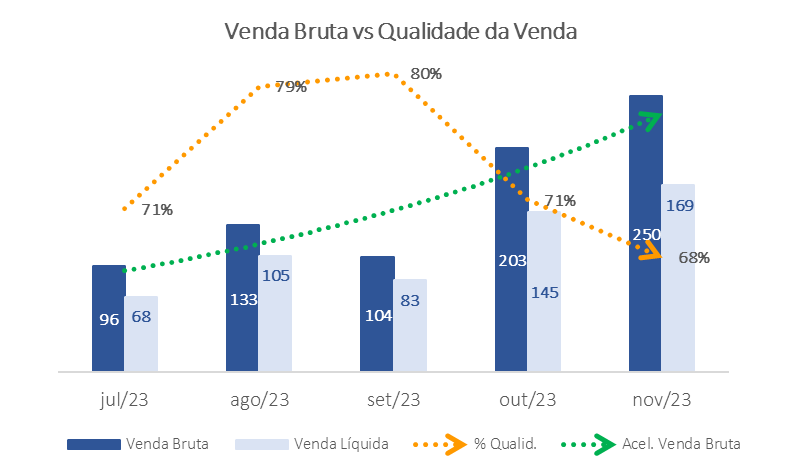

In [45]:
from IPython.display import Image
Image('/content/drive/MyDrive/Colab Notebooks/repositorio_remoto/a.vendabruta_qualidade.png')

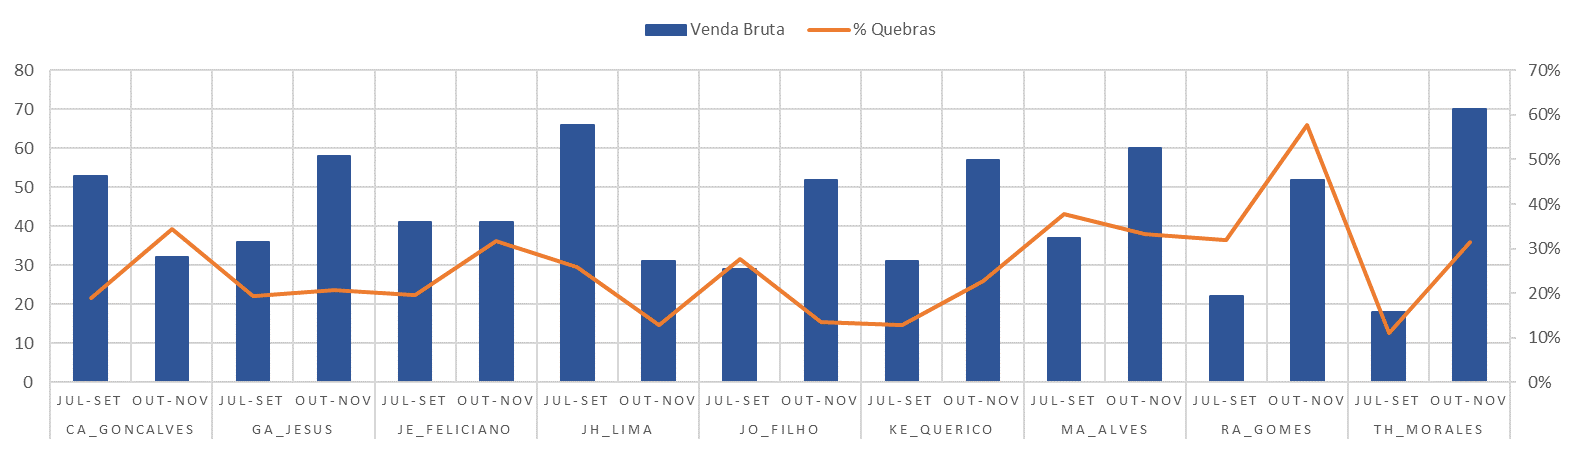

In [46]:
from IPython.display import Image
Image('/content/drive/MyDrive/Colab Notebooks/repositorio_remoto/c.vendabruta_%quebras_por_periodo.png')

Como podemos analisar no gráfico acima que houve uma aceleração exponencial no volume de venda bruta. Portanto, precisamos avaliar a qualidade desse crescimento.

Analisando o padrão de crescimento, podemos dividir essa análise em dois períodos para fins comparativos, jul-set e out-nov. Nesse sentido, vamos analisar por vendedor, a variação de venda bruta e % qualidade


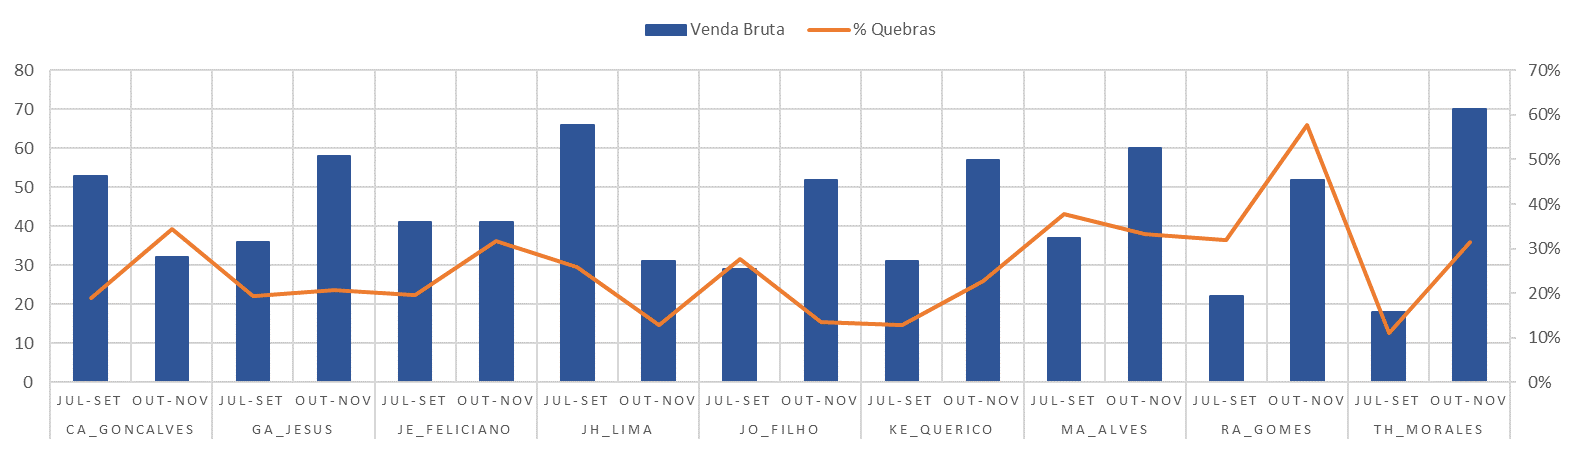

In [44]:
from IPython.display import Image
Image('/content/drive/MyDrive/Colab Notebooks/repositorio_remoto/c.vendabruta_%quebras_por_periodo.png')

Podemos perceber que 6 dos 9 vendedores, tiveram aceleração de venda entre os periodos, sendo:
*  Vendedor **TH_MORALES** outlier de aceleração, com 289% sobre as vendas do periodo anterior, apesar do aumento de 20 p.p. sobre o % de quebra;
*  Vendedores **MA_ALVES, GA_JESUS e KE_QUERICO** indices de aceleração e quebras proporcionais entre sí;
*  Vendedora **RA_GOMES** como aceleração de 136%, porém, com **maior índice de quebra**, sendo assim, podemos considerar performance **ofensora de qualidade**;
*  Vendedor **JO_FILHO** com aceleração de 79% sobre as vendas do periodo anterior e desaceleração de -14% sobre o indicador de quebras, sendo assim, podemos considerar que possui a **estratégia mais qualitativa** de vendas;

Analisando mais detalhadamente a variação de quebras de um período para o outro, temos:

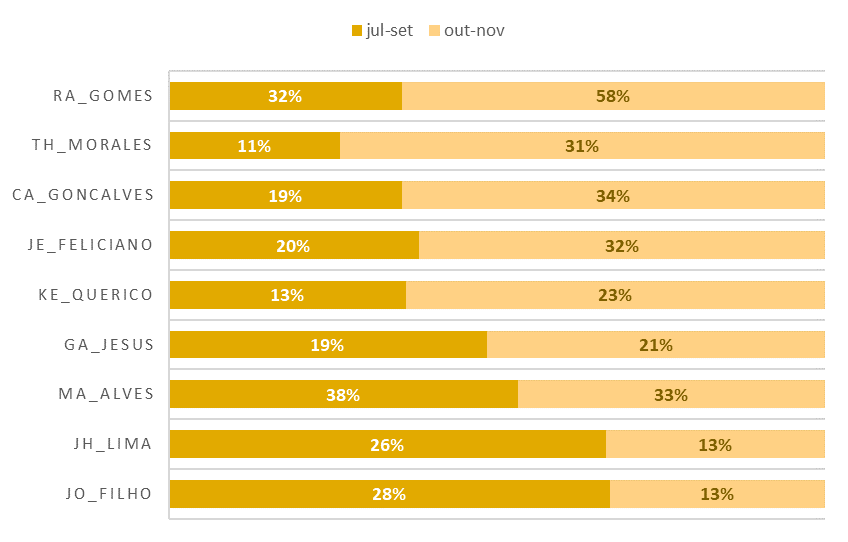

In [18]:
from IPython.display import Image
Image('/content/drive/MyDrive/Colab Notebooks/repositorio_remoto/b.quebras_por_vendedor_por_periodo.png')

Abertura por motivos, percebemos aumento de quebras por motivo de **Fatura Vencida** e **Churn**.

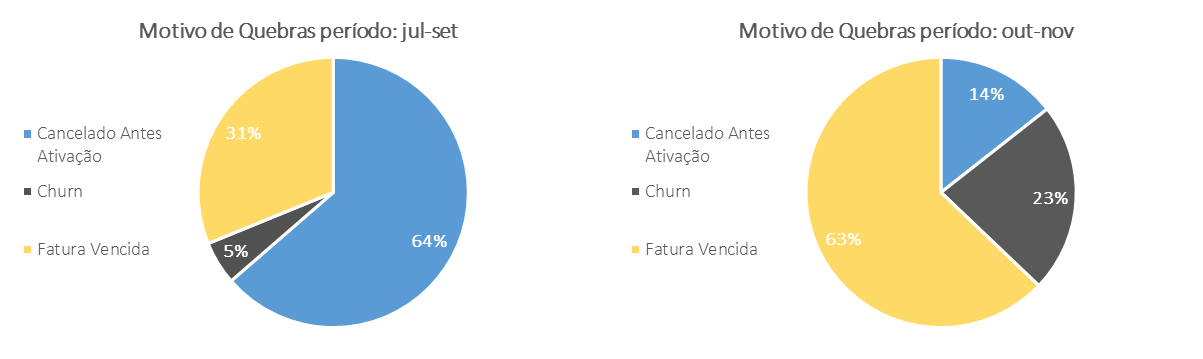

In [19]:
from IPython.display import Image
Image('/content/drive/MyDrive/Colab Notebooks/repositorio_remoto/d.pizza_motivos_gerl.png')

Abaixo a distribuição desses motivos por vendedor que teve aumento de quebra.

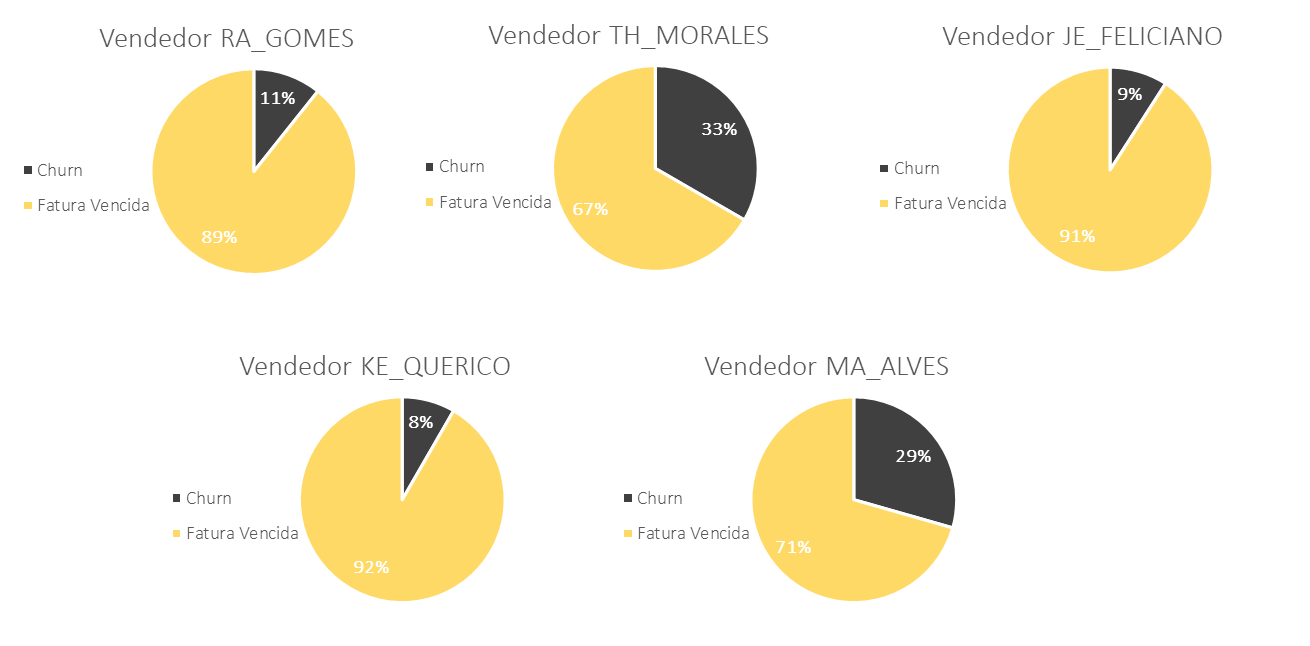

In [20]:
from IPython.display import Image
Image('/content/drive/MyDrive/Colab Notebooks/repositorio_remoto/e.motivos_por_vendedor.png')

Podemos concluir, que Faturas Vencidas é o principal motivo de o indicador de quebras ter aumentado, tanto de maneira geral, quanto por vendedor.

## 4. Pré-Processamento de dados

Nesta etapa, vamos verificar se há necessidade de tratamentos.

### 4.1. Analisando possiveis tratamentos

Verificação de missings

In [21]:
# Verificação de missing
dataset.isnull().sum()

id_venda           0
vendedor           0
cliente            0
uf_cidade          0
data_criacao       0
status_contrato    0
status_fatura      0
mes                0
venda_bruta        0
venda_liquida      0
dtype: int64

Faremos uma cópia do dataset para exemplo de tratamentos básicos.

<Axes: >

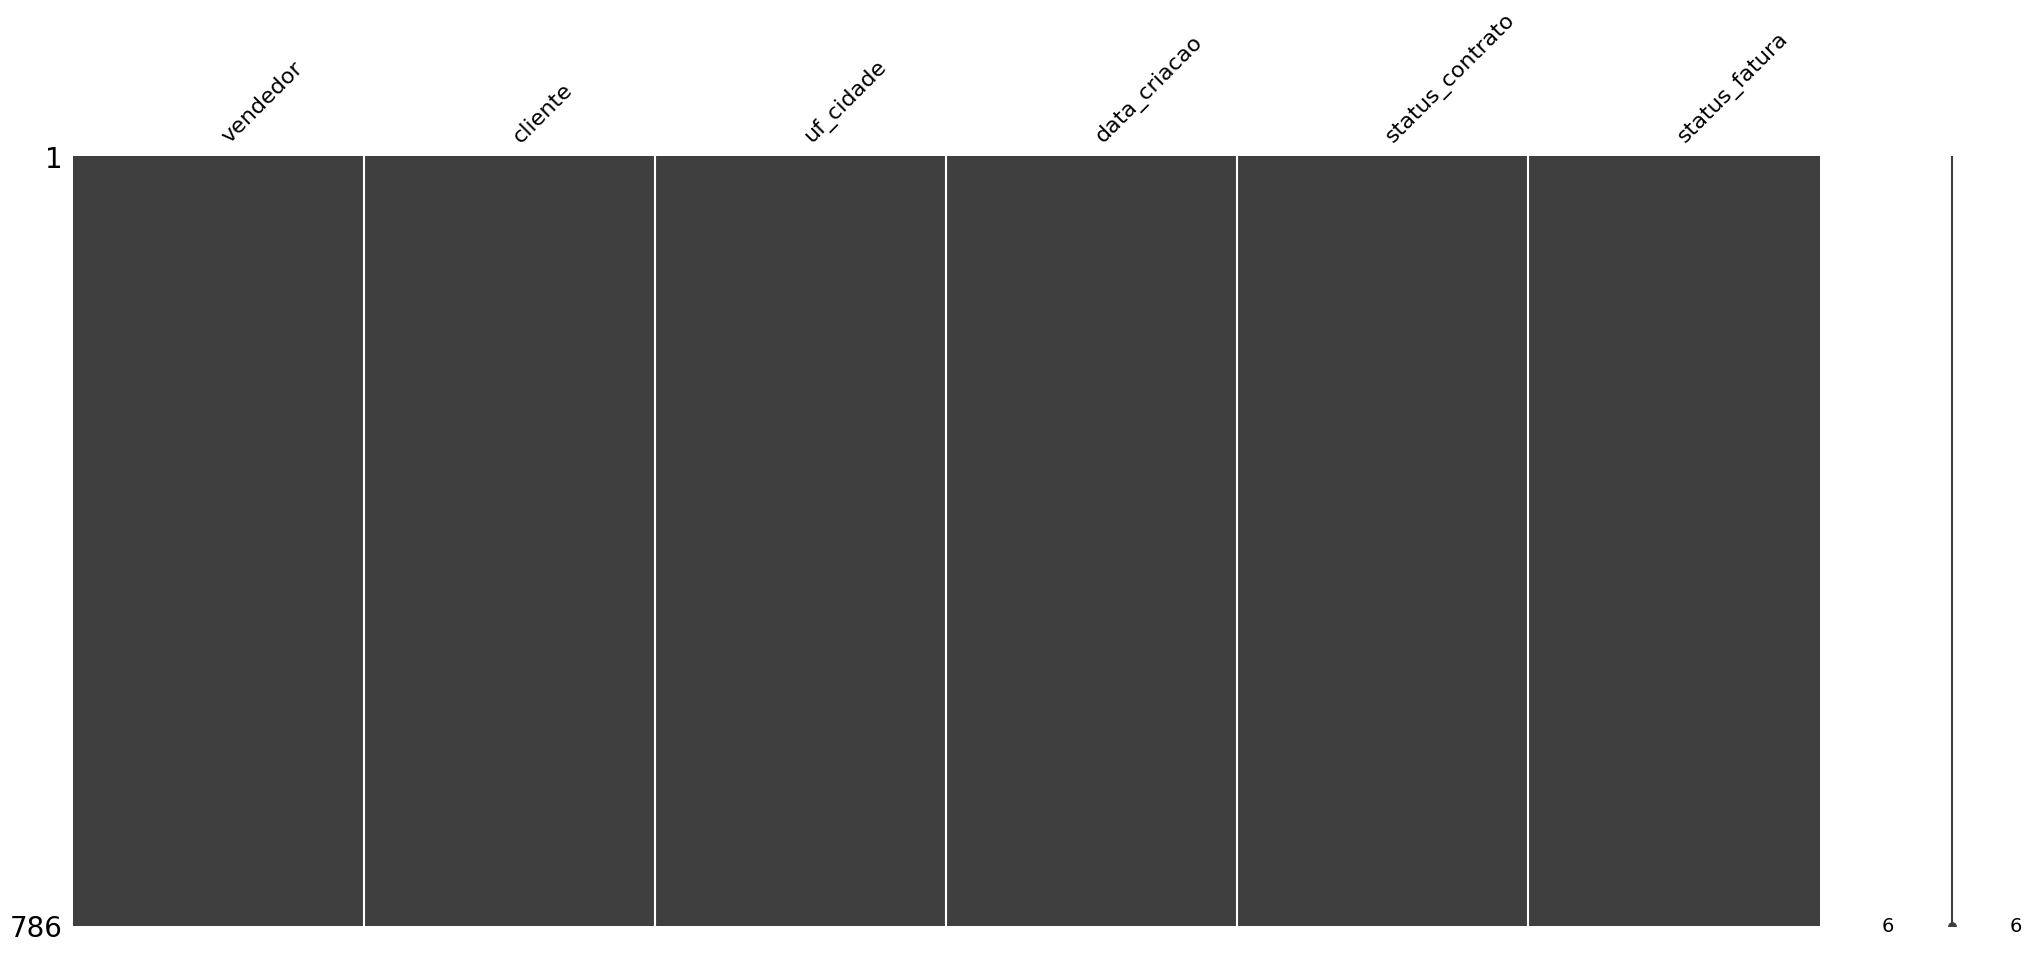

In [22]:
# Cópia do dataset para manipulação

# Nomes das colunas
col = list(dataset.columns)

# Escolha de colunas a serem eliminadas
atributos = dataset[col[1:-3]]

# exibindo visualização matricial da nulidade do dataset
ms.matrix(atributos)

In [23]:
# Salvando o dataset para testes futuros
datasetSemMissings = atributos

# exibindo as primeiras linhas
datasetSemMissings.head()

,vendedor,cliente,uf_cidade,data_criacao,status_contrato,status_fatura
0,JO_FILHO,PEDRO_ROCHA,RJ_MAGE,01/07/2023,Ativado,Paga
1,GA_JESUS,JESSICA_HENRIQUE,SP_CARAGUATATUBA,03/07/2023,Ativado,Paga
2,KE_QUERICO,LEONARDO_SZABO,SP_ILHABELA,03/07/2023,Ativado,Paga
3,CA_GONCALVES,CLERIA_HETTIENE,MG_UBERABA,03/07/2023,Ativado,Paga
4,RA_GOMES,TATIANA_APARECIDA,RJ_ITATIAIA,04/07/2023,Ativado,Paga


## Conclusão

Neste MVP analisamos um dataset de vendas, avaliando a performance quantitativa e qualitava da força de venda.
A análise quantitativa nos permitiu avaliar a aceleração de vendas, enquanto a qualitativa nos permitiu avaliar a estratégia mais assertiva por vendedor.
Este trabalho foi desenvolvido no google colab, em código python com gráficos em excel, importado como arquivo png.


